In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import sys
from modules_gd.model import VAE
# help(VAE)
from modules_gd.data import MSA_Dataset
# help(MSA_Dataset)

## Inspect the pre-processed MSA

In [51]:
MSA_id = "PF00565"
query_seq_id = "SND1_HUMAN/552-660"
outgroup_acc = "A0A060HE43"
data_path = f"data/Ding/processed/{MSA_id}"

In [52]:
!echo Total number of sequences:
! wc -l {data_path}/seq_msa_char.txt 
!echo Check that query sequence present:
! grep {query_seq_id} {data_path}/seq_msa_char.txt 
!echo Check that outgroup sequence present:
! grep {outgroup_acc} {data_path}/seq_msa_char.txt
!echo Print first 25 sequences:
! head -n 25 {data_path}/seq_msa_char.txt 

Total number of sequences:


    7907 data/Ding/processed/PF00565/seq_msa_char.txt
Check that query sequence present:
SND1_HUMAN/552-660	FLLAGIECPRGARNLPEGEPFSEEATLFTKELVLQREVEVEVESMDKAGNFIGWLHIDGANLSVLLVEHALSKVHFTAERSSYYKSLLSAEEAAKQKKEKVWA
Check that outgroup sequence present:
A0A060HE43_9ARCH/86-213	....................................KTAVIPTGEDRYGRMLAYISPWRKTFNLEMVETGWAASFPIYPGNDDMNRLIAGAEDAWNGKKGMWA
Print first 25 sequences:
A0A8C5HDE5_9TELE/219-327	VMLSGVKCPSFKREADTPEPFAAEAKFFTESRLLQRDVQIIL.ESCPNQIILGTILHPNGNITELLLKEGFARCVDSMAYTQGAEKLRAAERSAKERKVRIWK
A0A674JB29_TERCA/360-489	IHLSSIRPPRLEGEGTYDIPYMFEAREFLRKKLIGKKVNVTVDYIAFSERTCATVAIGGINIAEALVSKGLATVIRYRQRSSHYDELLAAEARAIKNGKGLHS
A0A6P8S9T6_GEOSA/362-491	IHLSSIRPPRLEGESAYDIPYMFEAREFLRKKLIGKKVNVTVDYISFSERTCATVSIGGINIAEALISKGLSTVIRYRQRSSHYDELLAAEARAIKNGKGLHS
A0A7N0RJ48_KALFE/412-550	VNLSSIRSPKMGNPRRKPAPYAREAKEFLRTRLIGQKVSVSMEYSDSKLMDFGSVFLVGPNVGELIVSRGFGTVIRHRDRSNHYDALLAAESRANSGKKGIH.
A0A8H7T8U9_9HELO/591-697	FVLGGIRAPKSARGPNKAEPFGQEAHDLATKRLTQRDVEVDVHSIDKVGGFIGEL

## Load data and instantiate dataset

In [53]:
## read in binary representation of MSA
with open(f"{data_path}/seq_msa_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([7907, 103, 21])

In [54]:
## each sequence has a label
with open(f"{data_path}/keys_list.pkl", 'rb') as file_handle:
    msa_keys = pickle.load(file_handle)
msa_keys[:10]

['A0A8C5HDE5_9TELE/219-327',
 'A0A674JB29_TERCA/360-489',
 'A0A6P8S9T6_GEOSA/362-491',
 'A0A7N0RJ48_KALFE/412-550',
 'A0A8H7T8U9_9HELO/591-697',
 'G7E1J5_MIXOS/214-330',
 'A0A8B9MDI9_9AVES/198-306',
 'S9WGZ8_9TRYP/305-410',
 'A0A8H5AF94_FUSOX/196-307',
 'G4U868_NEUT9/30-140']

In [58]:
## sequences in msa are weighted
with open(f"{data_path}/seq_weight.pkl", 'rb') as file_handle:
    seq_weight = pickle.load(file_handle)
seq_weight = seq_weight.astype(np.float32)
print(np.sum(seq_weight))

1.0


In [59]:
data = MSA_Dataset(msa_binary, seq_weight, msa_keys)
# Show a random sample
data[100]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 4.7288784e-05,
 'A0A5D2X2E8_GOSMU/42-152')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [60]:
# For architecture hyper-parameters, we rely on the defaults in the class definition
model = VAE(nl = nl, nc = nc, dim_latent_vars = 2)

Let's check that our model processes data the way we want it to

In [62]:
#Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
#Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim = 1))

Mean and variance of latent vector:
(tensor([[0.0110, 0.0073]], grad_fn=<AddmmBackward0>), tensor([[0.9767, 0.9818]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 103, 21]) and is given by:
tensor([[[-3.0690, -3.0826, -2.9739,  ..., -3.2460, -2.9670, -3.1517],
         [-3.0716, -3.1264, -3.1211,  ..., -3.0548, -2.9460, -3.0063],
         [-3.1881, -3.1289, -3.0095,  ..., -2.9067, -3.0067, -3.0652],
         ...,
         [-2.9372, -3.0674, -3.1261,  ..., -3.1250, -2.9863, -3.1588],
         [-3.0995, -2.9743, -2.9852,  ..., -2.9454, -3.0591, -3.1884],
         [-2.9455, -3.1775, -3.0037,  ..., -2.9595, -3.1629, -3.0806]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0465, 0.0458, 0.0511,  ..., 0.0389, 0.0515, 0.0428],
        [0.0463, 0.0439, 0.0441,  ..., 0.0471, 0.0525, 0.0495],
        [0.0412, 0.0438, 0.0493,  ..., 0.0547, 0.0495, 0.0466],
        ...,
        [0.0530, 0.0465, 0.0439,  ..., 0.0439, 0

## Train model

In [68]:
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(range(len(data)), test_size = 0.1)
train_loader = DataLoader(data, batch_size = 32, sampler = torch.utils.data.SubsetRandomSampler(train_idx))
test_loader = DataLoader(data, batch_size = 32, sampler = torch.utils.data.SubsetRandomSampler(test_idx))

In [70]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == "cuda":
  model.cuda()

# Training hyperparameters
num_epochs = 30
weight_decay = 0.01
dim_lat = 2
batch_size = 32
verbose = False

# Define how to do an epoch of training
def train(model, device, train_loader, optimizer, epoch, verbose):

  model.train()
  running_loss = []

  for batch_idx, (msa, weight, _) in enumerate(train_loader):
    msa, weight = msa.to(device), weight.to(device)
    optimizer.zero_grad()
    loss = (-1)*model.compute_weighted_elbo(msa, weight)
    loss.backward()
    optimizer.step()
    loss_scalar = loss.data.item()
    if verbose:
      print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, loss_scalar), \
            flush = True)
    running_loss.append(loss_scalar)

  return running_loss

# Define how to evaluate the model on the validation data
def eval(model, device, valid_loader, recon = False):

  model.eval()
  elbos = []
  if recon:
    recon_accs = []
  with torch.no_grad():
    for (msa, _, _) in valid_loader:
      msa = msa.to(device)
      # compute elbo loss
      elbo = model.compute_elbo_with_multiple_samples(msa, 100)
      elbo_scalar = torch.sum(elbo).data.item()
      elbos.append(elbo_scalar)


      if recon:
        # compute proportion of amino acids correctly reconstructed
        real = torch.argmax(msa, -1)
        mu, sigma = model.encoder(msa)
        p = torch.exp(model.decoder(mu))
        preds = torch.argmax(p, -1)
        recon_acc = torch.sum(real == preds)/real.nelement()
        recon_acc_scalar = recon_acc.data.item()
        recon_accs.append(recon_acc_scalar)

  return elbos, recon_accs



cpu


In [ ]:
train_losses = []
test_elbos = []
test_recon_accs = []

# Instantiate a new model for this fold
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay = weight_decay)
for epoch in range(num_epochs):
  batch_elbos, batch_recon_accs = eval(model, device, test_loader, recon = True)
  epoch_test_elbo, epoch_test_recon_acc = np.mean(batch_elbos), np.mean(batch_recon_accs)
  test_elbos.append(epoch_test_elbo)
  test_recon_accs.append(epoch_test_recon_acc)
  print(f"Test elbo for epoch {epoch}: {epoch_test_elbo}")
  print(f"Test reconstruction accuracy for fold epoch {epoch}: {epoch_test_recon_acc}")
  batch_losses = train(model, device, train_loader, optimizer, epoch, verbose)
  epoch_train_loss = np.mean(batch_losses)
  train_losses.append(epoch_train_loss)
  print(f"Training loss for epoch {epoch}: {epoch_train_loss}")
  

In [93]:
# Save model
from datetime import date
model.cpu()
today = date.today()
torch.save(model.state_dict(), f"saved_models/{MSA_id}/model_{today}.pt")

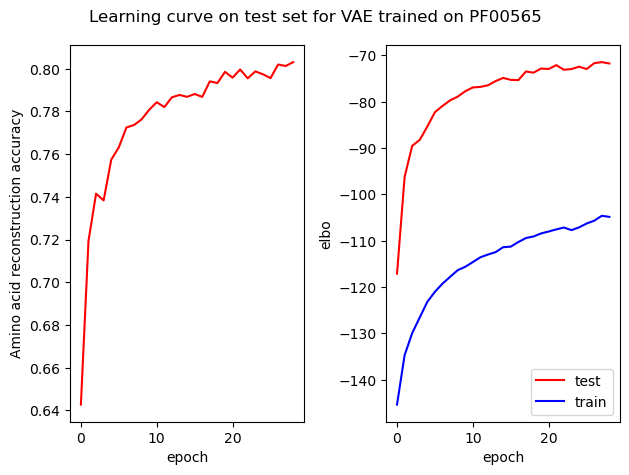

In [86]:
# plot learning curve
fig, axs = plt.subplots(1, 2)

axs[0].plot(test_recon_accs[1:], color = 'r')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel(f"Amino acid reconstruction accuracy")

axs[1].plot([x/batch_size for x in test_elbos[1:]], label = "test", color = 'r')
axs[1].plot([-x for x in train_losses[1:]], label = "train", color = 'b')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel(f"elbo")
axs[1].legend()

# add title
plt.suptitle(f"Learning curve on test set for VAE trained on {MSA_id}")
plt.tight_layout()
